# Vision Transformers (PyTorch)

This notebook demonstrates how to implement a Vision Transformer (ViT) model using PyTorch and the `vit-pytorch` library.
The ViT model is a powerful architecture for image classification tasks, leveraging the transformer architecture originally designed for natural language processing.

The transfer learning approach used here are similar to the previous notebook where VGG16 was used. The main difference is that we are using a Vision Transformer model instead of a CNN.

In [1]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


# Hugging Face datasets
from datasets import load_dataset

c:\Users\stiva001\AppData\Local\anaconda3\envs\ml_class\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters and device

In [2]:
batch_size = 128
EPOCHS = 20
lr = 1e-3
gamma = 0.7
IMG_SIZE = 224 # The image dimension should be 224x224 for the minimum requeriment of ViT
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Load dataset from Hugging Face and create PyTorch Dataset wrapper

In [3]:
from datasets import concatenate_datasets

# Load dataset (this will download if not present)
ds_full = load_dataset("microsoft/cats_vs_dogs")['train']

# Select 500 cats and 500 dogs
cats = ds_full.filter(lambda x: x['labels'] == 0).select(range(500))
dogs = ds_full.filter(lambda x: x['labels'] == 1).select(range(500))

# Concatenate and shuffle
subset = concatenate_datasets([cats, dogs]).shuffle(seed=42)

# Split into train and validation
ds = subset.train_test_split(test_size=0.2, seed=42)
hf_train = ds['train']
hf_valid = ds['test']
print('HF train size:', len(hf_train), 'HF val size:', len(hf_valid))

HF train size: 800 HF val size: 200


In [4]:
# transforms
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomResizedCrop(IMG_SIZE),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

class HFViTDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.ds = hf_dataset
        self.transform = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, idx):
        item = self.ds[int(idx)]
        img = item['image']
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = int(item['labels'])
        return img, label

train_dataset = HFViTDataset(hf_train, transform=train_transforms)
valid_dataset = HFViTDataset(hf_valid, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print('Train size:', len(train_dataset), 'Valid size:', len(valid_dataset))

Train size: 800 Valid size: 200


## Build ViT model (using vit-pytorch)

In [5]:
# Use torchvision's pretrained ViT (vit_b_32) from ImageNet
from torchvision import models as tv_models

weights = tv_models.ViT_B_32_Weights.IMAGENET1K_V1
model = tv_models.vit_b_32(weights=weights).to(device)

for params in model.parameters():
    params.requires_grad = False

# get the size of last attention layer inside the ViT
in_features = model.heads.head.in_features

# create the new classification layer
model.heads = nn.Sequential(
    nn.Linear(in_features, 2),
    nn.Sigmoid())

model.to(device)
print(model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

## Loss, optimizer and scheduler

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

## Training loop

In [7]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc.item() / len(train_loader)
        epoch_loss += loss.item() / len(train_loader)

    model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc.item() / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)

    # scheduler.step()
    print(f'Epoch {epoch+1}/{EPOCHS} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss: {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(epoch_val_loss)
    val_accuracy.append(epoch_val_accuracy)

Epoch 1/20 - loss: 0.6147 - acc: 0.7946 - val_loss: 0.5465 - val_acc: 0.8789
Epoch 2/20 - loss: 0.5252 - acc: 0.9096 - val_loss: 0.4857 - val_acc: 0.9340
Epoch 3/20 - loss: 0.4808 - acc: 0.9475 - val_loss: 0.4473 - val_acc: 0.9379
Epoch 4/20 - loss: 0.4405 - acc: 0.9721 - val_loss: 0.4226 - val_acc: 0.9596
Epoch 5/20 - loss: 0.4174 - acc: 0.9732 - val_loss: 0.4074 - val_acc: 0.9488
Epoch 6/20 - loss: 0.4053 - acc: 0.9721 - val_loss: 0.3973 - val_acc: 0.9488
Epoch 7/20 - loss: 0.3902 - acc: 0.9799 - val_loss: 0.3900 - val_acc: 0.9527
Epoch 8/20 - loss: 0.3836 - acc: 0.9833 - val_loss: 0.3848 - val_acc: 0.9488
Epoch 9/20 - loss: 0.3779 - acc: 0.9821 - val_loss: 0.3806 - val_acc: 0.9527
Epoch 10/20 - loss: 0.3701 - acc: 0.9833 - val_loss: 0.3774 - val_acc: 0.9527
Epoch 11/20 - loss: 0.3654 - acc: 0.9866 - val_loss: 0.3746 - val_acc: 0.9527
Epoch 12/20 - loss: 0.3640 - acc: 0.9844 - val_loss: 0.3723 - val_acc: 0.9527
Epoch 13/20 - loss: 0.3588 - acc: 0.9877 - val_loss: 0.3702 - val_acc: 0.

## Plot results and save model

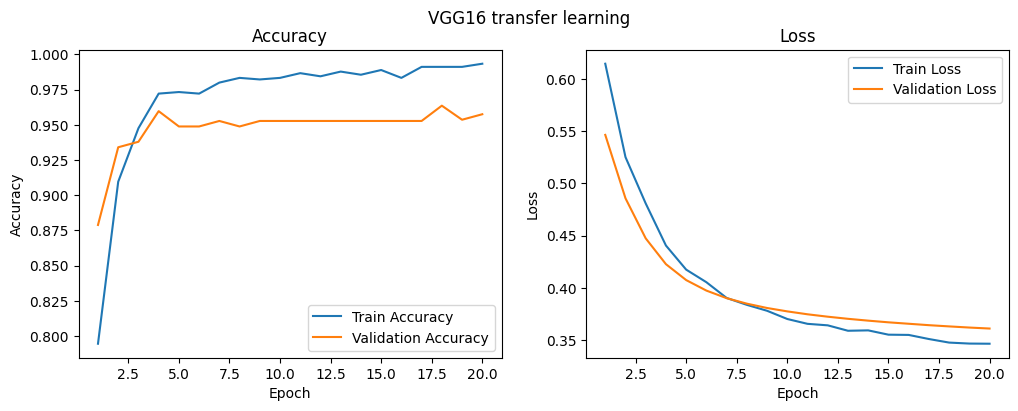

Saved model to ViT_model_pytorch.pt


In [8]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(epochs, train_accuracy, label='Train Accuracy')
ax1.plot(epochs, val_accuracy, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, train_losses, label='Train Loss')
ax2.plot(epochs, val_losses, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('VGG16 transfer learning')
plt.show()

torch.save(model.state_dict(), 'ViT_model_pytorch.pt')
print('Saved model to ViT_model_pytorch.pt')

### Exercise: 

Go to the [Vit-pytorch documentation](https://docs.pytorch.org/vision/main/models/vision_transformer.html) and explore other Vision Transformer architectures available. Change the code to use a different ViT architecture and see how it performs on the Cats vs Dogs dataset.

In [9]:
# Use torchvision's pretrained ViT (vit_b_32) from ImageNet
from torchvision import models as tv_models

# new_weights = ### GET NEW WEIGHTS
# new_model = ### GET NEW MODEL

new_weights = tv_models.ViT_B_16_Weights.IMAGENET1K_V1
new_model = tv_models.vit_b_16(weights=new_weights)

for params in new_model.parameters():
    params.requires_grad = False

# get the size of last attention layer inside the ViT
in_features = new_model.heads.head.in_features

# create the new classification layer
new_model.heads = nn.Sequential(
    nn.Linear(in_features, 2),
    nn.Sigmoid())

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(new_model.heads.parameters(), lr=lr)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

new_model.to(device)
print(new_model)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

After you selected a different ViT architecture, run the following code to load the new model and train it:

In [10]:
new_train_losses = []
new_train_accuracy = []
new_val_losses = []
new_val_accuracy = []

for epoch in range(EPOCHS):
    epoch_loss = 0
    epoch_accuracy = 0
    new_model.train()
    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        output = new_model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc.item() / len(train_loader)
        epoch_loss += loss.item() / len(train_loader)

    new_model.eval()
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = new_model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc.item() / len(valid_loader)
            epoch_val_loss += val_loss.item() / len(valid_loader)

    # scheduler.step()
    print(f'Epoch {epoch+1}/{EPOCHS} - loss: {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss: {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}')
    new_train_losses.append(epoch_loss)
    new_train_accuracy.append(epoch_accuracy)
    new_val_losses.append(epoch_val_loss)
    new_val_accuracy.append(epoch_val_accuracy)

Epoch 1/20 - loss: 0.6387 - acc: 0.8058 - val_loss: 0.5727 - val_acc: 0.9510
Epoch 2/20 - loss: 0.5414 - acc: 0.9632 - val_loss: 0.4958 - val_acc: 0.9666
Epoch 3/20 - loss: 0.4759 - acc: 0.9710 - val_loss: 0.4481 - val_acc: 0.9705
Epoch 4/20 - loss: 0.4330 - acc: 0.9743 - val_loss: 0.4178 - val_acc: 0.9705
Epoch 5/20 - loss: 0.4080 - acc: 0.9777 - val_loss: 0.3994 - val_acc: 0.9705
Epoch 6/20 - loss: 0.3902 - acc: 0.9799 - val_loss: 0.3876 - val_acc: 0.9705
Epoch 7/20 - loss: 0.3790 - acc: 0.9766 - val_loss: 0.3793 - val_acc: 0.9705
Epoch 8/20 - loss: 0.3739 - acc: 0.9788 - val_loss: 0.3734 - val_acc: 0.9705
Epoch 9/20 - loss: 0.3669 - acc: 0.9844 - val_loss: 0.3689 - val_acc: 0.9705
Epoch 10/20 - loss: 0.3645 - acc: 0.9821 - val_loss: 0.3654 - val_acc: 0.9705
Epoch 11/20 - loss: 0.3582 - acc: 0.9866 - val_loss: 0.3625 - val_acc: 0.9705
Epoch 12/20 - loss: 0.3522 - acc: 0.9866 - val_loss: 0.3602 - val_acc: 0.9705
Epoch 13/20 - loss: 0.3546 - acc: 0.9810 - val_loss: 0.3583 - val_acc: 0.

Now plot the training and validation loss and accuracy curves of the new model and compare them with the previous ViT model.

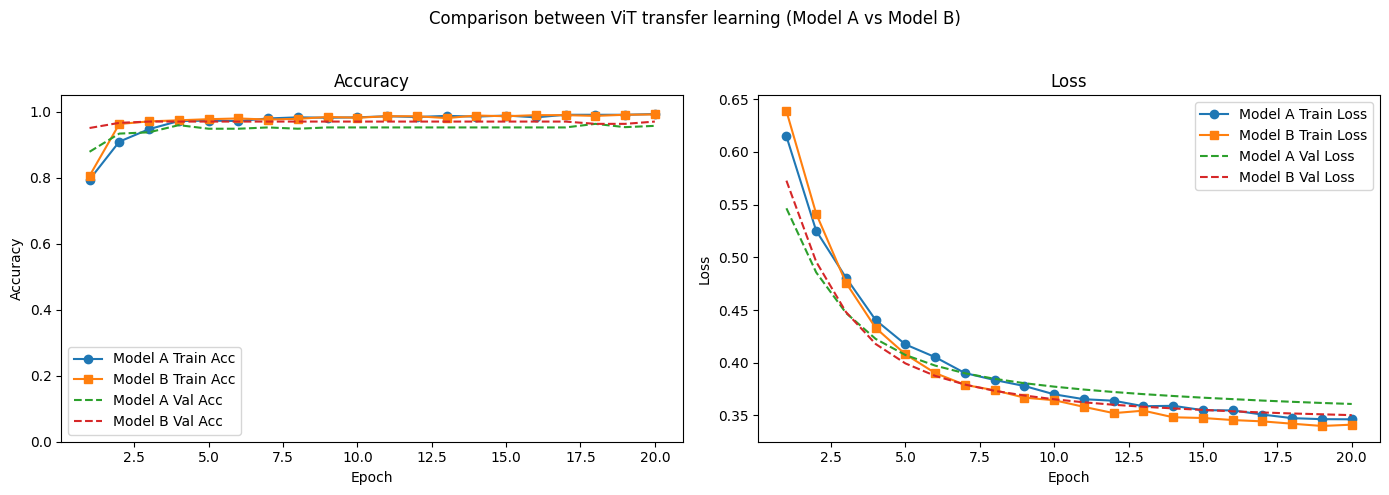

In [11]:
epochs = list(range(1, EPOCHS+1))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison (train + val for both models)
ax1.plot(epochs, train_accuracy, marker='o', label='Model A Train Acc')
ax1.plot(epochs, new_train_accuracy, marker='s', label='Model B Train Acc')
ax1.plot(epochs, val_accuracy, linestyle='--', label='Model A Val Acc')
ax1.plot(epochs, new_val_accuracy, linestyle='--', label='Model B Val Acc')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.05)
ax1.legend()

# Loss comparison (train + val for both models)
ax2.plot(epochs, train_losses, marker='o', label='Model A Train Loss')
ax2.plot(epochs, new_train_losses, marker='s', label='Model B Train Loss')
ax2.plot(epochs, val_losses, linestyle='--', label='Model A Val Loss')
ax2.plot(epochs, new_val_losses, linestyle='--', label='Model B Val Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('Comparison between ViT transfer learning (Model A vs Model B)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()